In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, activations, layers, regularizers
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, Nadam
from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import numpy as np

import time
# Reproducibility
import os, random
import numpy as np
import tensorflow as tf
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.keras.utils.set_random_seed(SEED)
except Exception:
    pass


# 

# load and prepare data

In [2]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

In [3]:
# Combine training and test data into a single dataset
X = np.concatenate((x_train_full, x_test), axis=0)
Y = np.concatenate((y_train_full, y_test), axis=0)
print("Dataset dimensions (X):", X.shape)
print("type (X):", X.dtype)
print("Dataset dimensions (Y):", Y.shape)
print("type (Y):", Y.dtype)

Dataset dimensions (X): (60000, 32, 32, 3)
type (X): uint8
Dataset dimensions (Y): (60000, 1)
type (Y): uint8


In [4]:
X = X / 255.0

In [5]:
# Get unique values in y_train
unique_y = np.unique(Y)

# Print the unique values
print("Unique values in y_train:", unique_y)

Unique values in y_train: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# Split the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)

## load old model

In [7]:
CIFAR10_oldver = keras.models.load_model('best_dense_model.h5', compile=False)

# حالا با Optimizer مناسب خودت دوباره کامپایل کن
CIFAR10_oldver.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# نمایش لایه‌های مدل قدیمی
for i, layer in enumerate(CIFAR10_oldver.layers):
    print(f"لایه {i}: {layer.name}, نوع: {type(layer).__name__}, شکل خروجی: {layer.output_shape}")

لایه 0: flatten, نوع: Flatten, شکل خروجی: (None, 3072)
لایه 1: dense, نوع: Dense, شکل خروجی: (None, 160)
لایه 2: dense_1, نوع: Dense, شکل خروجی: (None, 256)
لایه 3: dense_2, نوع: Dense, شکل خروجی: (None, 256)
لایه 4: dense_3, نوع: Dense, شکل خروجی: (None, 10)


In [9]:
CIFAR10_oldver.layers[3].trainable

True

In [10]:
CIFAR10_oldver.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 160)               491680    
                                                                 
 dense_1 (Dense)             (None, 256)               41216     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 601,258
Trainable params: 601,258
Non-trainable params: 0
_________________________________________________________________


# clone 

In [11]:
CIFAR10_older_clone=keras.models.clone_model(CIFAR10_oldver)
CIFAR10_older_clone.set_weights(CIFAR10_oldver.get_weights())

# re shape old model (cloned)

In [12]:
for layer in CIFAR10_older_clone.layers:
    if isinstance(layer, layers.Dense) and layer != CIFAR10_older_clone.layers[-1]:
        layer.activation = activations.selu
        layer.kernel_initializer = initializers.lecun_normal()
        layer.bias_initializer = initializers.Zeros()

In [13]:
# CIFAR10_older_clone.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history_selu_clone = CIFAR10_older_clone.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# or create a very simple model

In [14]:
model_selu = keras.models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(60, activation='selu'),
    
    layers.Dense(30, activation='selu'),
    
    layers.Dense(15, activation='selu'),
    
    layers.Dense(10, activation='softmax') 
])

# کامپایل مدل
model_selu.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# مدل خلاصه
model_selu.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 60)                184380    
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 10)                160       
                                                                 
Total params: 186,835
Trainable params: 186,835
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_model_selu = model_selu.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1355/1355 [==============================] - 4s 3ms/step - loss: 1.9674 - accuracy: 0.2818 - val_loss: 1.7920 - val_accuracy: 0.3454
Epoch 2/50
1355/1355 [==============================] - 4s 3ms/step - loss: 1.7669 - accuracy: 0.3624 - val_loss: 1.6883 - val_accuracy: 0.3835
Epoch 3/50
1355/1355 [==============================] - 4s 3ms/step - loss: 1.6887 - accuracy: 0.3918 - val_loss: 1.6288 - val_accuracy: 0.4140
Epoch 4/50
1355/1355 [==============================] - 4s 3ms/step - loss: 1.6374 - accuracy: 0.4115 - val_loss: 1.6443 - val_accuracy: 0.4176
Epoch 5/50
1355/1355 [==============================] - 4s 3ms/step - loss: 1.5958 - accuracy: 0.4253 - val_loss: 1.5720 - val_accuracy: 0.4397
Epoch 6/50
1355/1355 [==============================] - 4s 3ms/step - loss: 1.5587 - accuracy: 0.4428 - val_loss: 1.5612 - val_accuracy: 0.4429
Epoch 7/50
1355/1355 [==============================] - 5s 3ms/step - loss: 1.5371 - accuracy: 0.4483 - val_loss: 1.5455 - val_accuracy:

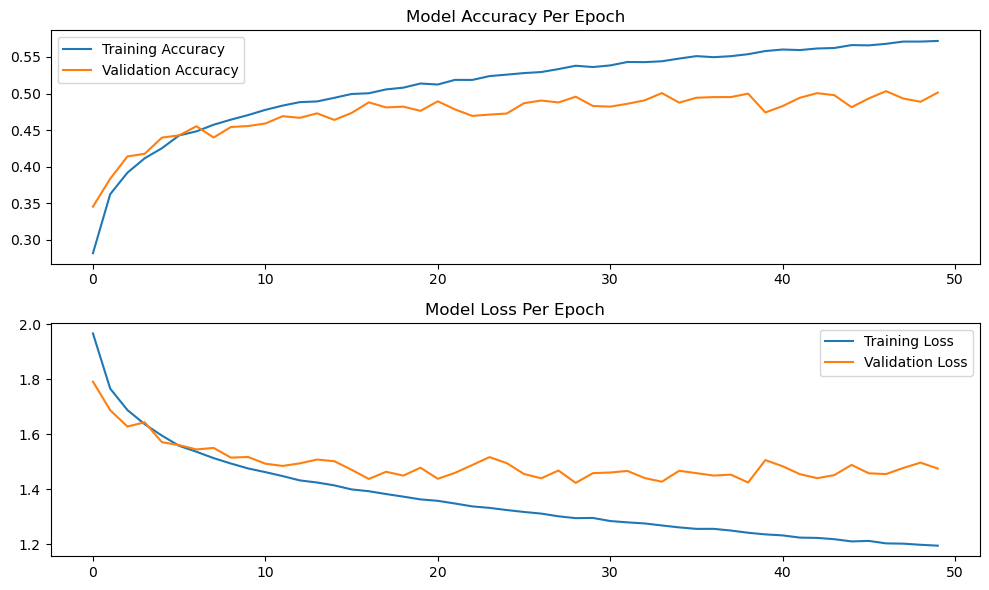

In [16]:
# Displaying Best Performance Charts
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(history_model_selu.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_selu.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy Per Epoch')

plt.subplot(2, 1, 2)
plt.plot(history_model_selu.history['loss'], label='Training Loss')
plt.plot(history_model_selu.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss Per Epoch')

plt.tight_layout()
plt.show()



## اضافه کردن Batch Normalization  و تعویض اکتیویشن ها

In [17]:
# تغییر لایه‌ها برای افزودن BatchNorm
bn_model = keras.models.clone_model(model_selu)
bn_model.set_weights(model_selu.get_weights())

In [18]:
for i, layer in enumerate(bn_model.layers):
    if isinstance(layer, layers.Dense) and i != len(bn_model.layers)-1:
        layer.activation = activations.relu
        bn_model.layers.insert(i+1, layers.BatchNormalization())

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
bn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_bn = bn_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1355/1355 [==============================] - 5s 3ms/step - loss: 1.2906 - accuracy: 0.5411 - val_loss: 1.4988 - val_accuracy: 0.4838
Epoch 2/50
1355/1355 [==============================] - 33s 24ms/step - loss: 1.2397 - accuracy: 0.5572 - val_loss: 1.5763 - val_accuracy: 0.4629
Epoch 3/50
1355/1355 [==============================] - 16s 12ms/step - loss: 1.2186 - accuracy: 0.5678 - val_loss: 1.4900 - val_accuracy: 0.4818
Epoch 4/50
1355/1355 [==============================] - 17s 13ms/step - loss: 1.2157 - accuracy: 0.5677 - val_loss: 1.5539 - val_accuracy: 0.4782
Epoch 5/50
1355/1355 [==============================] - 15s 11ms/step - loss: 1.2074 - accuracy: 0.5700 - val_loss: 1.4932 - val_accuracy: 0.4867
Epoch 6/50
1355/1355 [==============================] - 15s 11ms/step - loss: 1.1977 - accuracy: 0.5722 - val_loss: 1.5460 - val_accuracy: 0.4748
Epoch 7/50
1355/1355 [==============================] - 11s 8ms/step - loss: 1.1948 - accuracy: 0.5738 - val_loss: 1.5382 - va

KeyboardInterrupt: 

## مقایسه نتایج SELU و BatchNorm

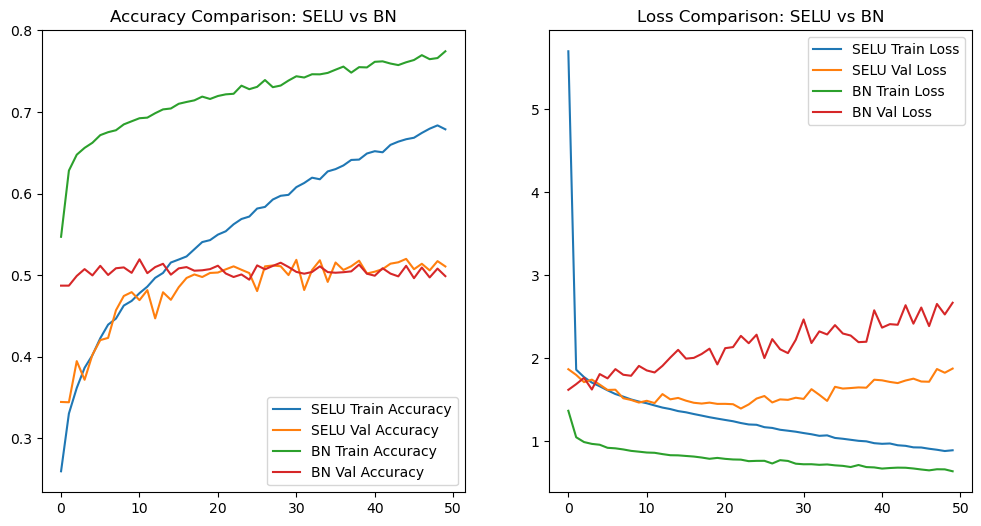

In [ ]:
# Plot comparison between SELU and BN
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_selu_clone.history['accuracy'], label='SELU Train Accuracy')
plt.plot(history_selu_clone.history['val_accuracy'], label='SELU Val Accuracy')
plt.plot(history_bn.history['accuracy'], label='BN Train Accuracy')
plt.plot(history_bn.history['val_accuracy'], label='BN Val Accuracy')
plt.legend()
plt.title('Accuracy Comparison: SELU vs BN')
plt.subplot(1, 2, 2)
plt.plot(history_selu_clone.history['loss'], label='SELU Train Loss')
plt.plot(history_selu_clone.history['val_loss'], label='SELU Val Loss')
plt.plot(history_bn.history['loss'], label='BN Train Loss')
plt.plot(history_bn.history['val_loss'], label='BN Val Loss')
plt.legend()
plt.title('Loss Comparison: SELU vs BN')
plt.show()

## decide horses

In [ ]:
y_train_horse = (y_train == 7).astype(int)
y_val_horse = (y_val == 7).astype(int)

In [ ]:
indices = np.random.choice(len(X_train) , 6000,replace = False)
x_train_horse_sub = X_train[indices]
y_train_horse_sub = y_train_horse[indices]

In [ ]:
y_train_horse_sub.shape

(6000, 1)

In [ ]:
x_train_horse_sub.shape

(6000, 32, 32, 3)

### مثال درک بیشتر کد

In [ ]:
# مثال 
indices_ = np.random.choice(10, 3, replace=False)

In [ ]:
#مثال 
X_train_ = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])
indices_ = np.array([2, 7, 4])
X_train_sub_ = X_train_[indices_]
print(X_train_sub_)  # خروجی: ['c', 'h', 'e']

['c' 'h' 'e']


In [ ]:
#مثال دیگر 
import numpy as np

# فرض می‌کنیم X_train و y_train از قبل لود شدن
X_train_ = np.random.rand(50000, 32, 32, 3)  # 50,000 تصویر 32x32x3
y_train_horse_ = np.random.randint(0, 2, 50000)  # برچسب‌های 0 و 1 برای اسب/غیراسب

# انتخاب تصادفی 6000 نمونه
indices_ = np.random.choice(len(X_train_), 6000, replace=False)
X_train_sub_ = X_train_[indices_]  # shape می‌شه (6000, 32, 32, 3)
y_train_sub_ = y_train_horse_[indices_]  # shape می‌شه (6000,)

print("اندازه داده‌های جدید:", X_train_sub_.shape)
print("اندازه برچسب‌های جدید:", y_train_sub_.shape)

اندازه داده‌های جدید: (6000, 32, 32, 3)
اندازه برچسب‌های جدید: (6000,)


### freaze

In [ ]:
# ایجاد مدل جدید با معماری صحیح
model_horse = keras.Sequential()
for layer in bn_model.layers[:-1]:  # افزودن همه لایه‌ها به جز لایه آخر
    model_horse.add(layer)
model_horse.add(layers.Dense(1, activation='sigmoid', name='horse_output'))  # لایه جدید با ۱ نورون

# فریز کردن لایه‌ها
for layer in model_horse.layers[:-1]:
    layer.trainable = False

model_horse.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# آموزش با لایه‌های فریز شده
start = time.time()
history_frozen = model_horse.fit(x_train_horse_sub, y_train_horse_sub, epochs=50, validation_split=0.2)
time_frozen = time.time() - start

Epoch 1/50
150/150 [==============================] - 1s 3ms/step - loss: 1.0649 - accuracy: 0.7260 - val_loss: 0.6091 - val_accuracy: 0.8417
Epoch 2/50
150/150 [==============================] - 0s 2ms/step - loss: 0.3971 - accuracy: 0.8913 - val_loss: 0.3988 - val_accuracy: 0.9017
Epoch 3/50
150/150 [==============================] - 0s 3ms/step - loss: 0.2616 - accuracy: 0.9248 - val_loss: 0.3296 - val_accuracy: 0.9275
Epoch 4/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9396 - val_loss: 0.2831 - val_accuracy: 0.9342
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1586 - accuracy: 0.9475 - val_loss: 0.2551 - val_accuracy: 0.9442
Epoch 6/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.9535 - val_loss: 0.2336 - val_accuracy: 0.9475
Epoch 7/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.9590 - val_loss: 0.2261 - val_accuracy: 0.9500
Epoch 

In [ ]:
print(f"Time with frozen layers: {time_frozen:.2f} seconds")
print(f"Final accuracy with frozen layers: {history_frozen.history['accuracy'][-1]:.4f}")
print(f"Final val accuracy with frozen layers: {history_frozen.history['val_accuracy'][-1]:.4f}")

Time with frozen layers: 17.82 seconds
Final accuracy with frozen layers: 0.9717
Final val accuracy with frozen layers: 0.9517


In [ ]:
# آزاد کردن همه لایه‌ها
for layer in model_horse.layers:
    layer.trainable = True

In [ ]:
model_horse.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# آموزش مجدد
start = time.time()
history_unfrozen = model_horse.fit(x_train_horse_sub, y_train_horse_sub, epochs=50, validation_split=0.2)
time_unfrozen = time.time() - start

Epoch 1/50
150/150 [==============================] - 1s 3ms/step - loss: 0.1716 - accuracy: 0.9469 - val_loss: 0.2534 - val_accuracy: 0.9267
Epoch 2/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.9450 - val_loss: 0.2250 - val_accuracy: 0.9400
Epoch 3/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1163 - accuracy: 0.9598 - val_loss: 0.2374 - val_accuracy: 0.9433
Epoch 4/50
150/150 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9583 - val_loss: 0.2275 - val_accuracy: 0.9375
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 0.0836 - accuracy: 0.9692 - val_loss: 0.3077 - val_accuracy: 0.9283
Epoch 6/50
150/150 [==============================] - 0s 2ms/step - loss: 0.0819 - accuracy: 0.9679 - val_loss: 0.3333 - val_accuracy: 0.9383
Epoch 7/50
150/150 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9740 - val_loss: 0.3416 - val_accuracy: 0.9333
Epoch 

In [ ]:
print(f"Time with unfrozen layers: {time_unfrozen:.2f} seconds")
print(f"Final accuracy with unfrozen layers: {history_unfrozen.history['accuracy'][-1]:.4f}")
print(f"Final val accuracy with unfrozen layers: {history_unfrozen.history['val_accuracy'][-1]:.4f}")

Time with unfrozen layers: 16.45 seconds
Final accuracy with unfrozen layers: 0.9996
Final val accuracy with unfrozen layers: 0.9333


In [ ]:
print(f"زمان آموزش با لایه‌های فریز: {time_frozen:.2f} ثانیه")
print(f"زمان آموزش بدون فریز: {time_unfrozen:.2f} ثانیه")

زمان آموزش با لایه‌های فریز: 17.82 ثانیه
زمان آموزش بدون فریز: 16.45 ثانیه


## compare optimizers

In [ ]:
# Test different optimizers
optimizers = {
    'SGD': SGD(learning_rate=0.01),
    'SGD_momentum': SGD(learning_rate=0.01, momentum=0.9),
    'Nesterov': SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'Adagrad': Adagrad(learning_rate=0.01),
    'Adam': Adam(learning_rate=0.01),
    'Nadam': Nadam(learning_rate=0.01)
}
histories = {}
for name, opt in optimizers.items():
    model_horse.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    histories[name] = model_horse.fit(x_train_horse_sub, y_train_horse_sub, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
150/150 [==============================] - 1s 3ms/step - loss: 9.8745e-04 - accuracy: 0.9998 - val_loss: 0.7865 - val_accuracy: 0.9325
Epoch 2/50
150/150 [==============================] - 0s 2ms/step - loss: 8.8912e-04 - accuracy: 0.9998 - val_loss: 0.7982 - val_accuracy: 0.9333
Epoch 3/50
150/150 [==============================] - 0s 2ms/step - loss: 8.1786e-04 - accuracy: 0.9998 - val_loss: 0.8040 - val_accuracy: 0.9333
Epoch 4/50
150/150 [==============================] - 0s 2ms/step - loss: 7.4790e-04 - accuracy: 0.9998 - val_loss: 0.8122 - val_accuracy: 0.9333
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 6.8952e-04 - accuracy: 1.0000 - val_loss: 0.8205 - val_accuracy: 0.9333
Epoch 6/50
150/150 [==============================] - 0s 2ms/step - loss: 6.3935e-04 - accuracy: 1.0000 - val_loss: 0.8237 - val_accuracy: 0.9350
Epoch 7/50
150/150 [==============================] - 0s 2ms/step - loss: 5.9763e-04 - accuracy: 1.0000 - val_loss: 0.8341 -

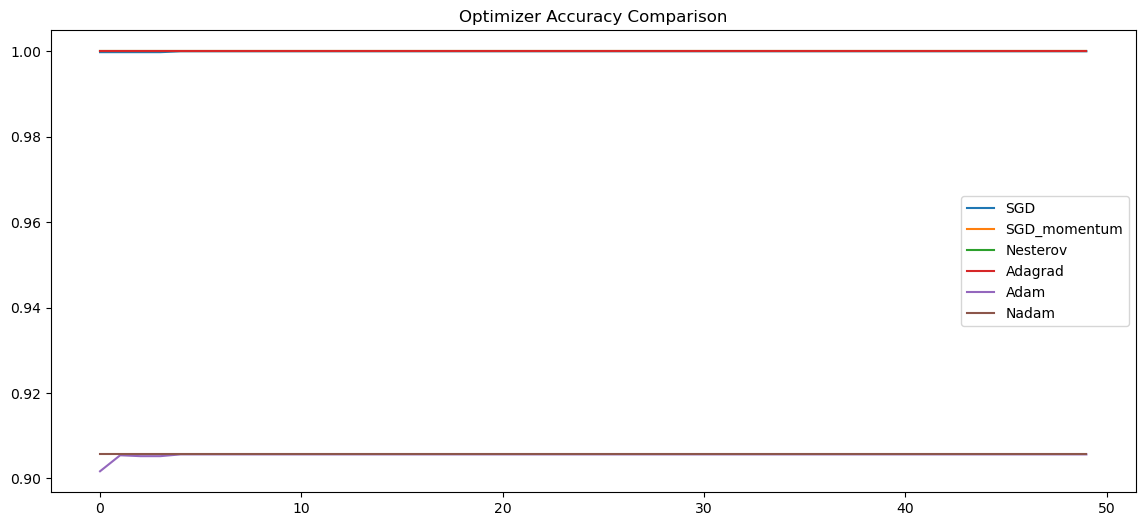

In [ ]:
plt.figure(figsize=(14, 6))
for opt_name in histories:
    plt.plot(histories[opt_name].history['accuracy'], label=opt_name)
plt.title('Optimizer Accuracy Comparison')
plt.legend()
plt.show()

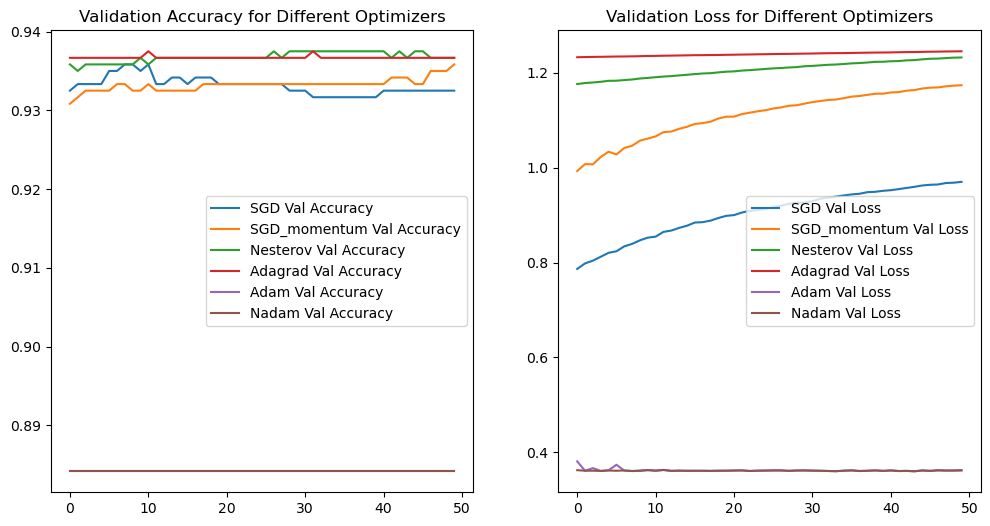

In [ ]:
# Plot optimizer comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Optimizers')
plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.legend()
plt.title('Validation Loss for Different Optimizers')
plt.show()

### افزودن Dropout و L1/L2
### برای مدل horse

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
# Regularization: Dropout
dropout_model = keras.models.clone_model(bn_model)
for i, layer in enumerate(dropout_model.layers):
    if isinstance(layer, layers.Dense) and i != len(dropout_model.layers)-1:
        dropout_model.layers.insert(i+1, layers.Dropout(0.5))
dropout_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_dropout = dropout_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.8613 - accuracy: 0.3227 - val_loss: 1.7090 - val_accuracy: 0.3820
Epoch 2/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.6995 - accuracy: 0.3866 - val_loss: 1.6216 - val_accuracy: 0.4122
Epoch 3/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.6336 - accuracy: 0.4119 - val_loss: 1.6082 - val_accuracy: 0.4203
Epoch 4/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.5844 - accuracy: 0.4298 - val_loss: 1.5684 - val_accuracy: 0.4383
Epoch 5/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.5431 - accuracy: 0.4433 - val_loss: 1.5046 - val_accuracy: 0.4608
Epoch 6/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.5173 - accuracy: 0.4526 - val_loss: 1.5383 - val_accuracy: 0.4476
Epoch 7/50
1355/1355 [==============================] - 3s 2ms/step - loss: 1.4891 - accuracy: 0.4651 - val_loss: 1.4870 - val_accuracy:

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
# Regularization: L1-L2
l1_l2_model = keras.models.clone_model(dropout_model)
l1_l2_model.set_weights(dropout_model.get_weights())
for layer in l1_l2_model.layers:
    if isinstance(layer, layers.Dense):
        layer.kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)
l1_l2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_l1_l2 = l1_l2_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8957 - accuracy: 0.6705 - val_loss: 2.0796 - val_accuracy: 0.4656
Epoch 2/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8608 - accuracy: 0.6834 - val_loss: 2.1971 - val_accuracy: 0.4612
Epoch 3/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8572 - accuracy: 0.6844 - val_loss: 2.3179 - val_accuracy: 0.4576
Epoch 4/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8522 - accuracy: 0.6853 - val_loss: 2.2376 - val_accuracy: 0.4505
Epoch 5/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8403 - accuracy: 0.6928 - val_loss: 2.2188 - val_accuracy: 0.4624
Epoch 6/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8418 - accuracy: 0.6904 - val_loss: 2.2810 - val_accuracy: 0.4607
Epoch 7/50
1355/1355 [==============================] - 3s 2ms/step - loss: 0.8272 - accuracy: 0.6963 - val_loss: 2.3237 - val_accuracy:

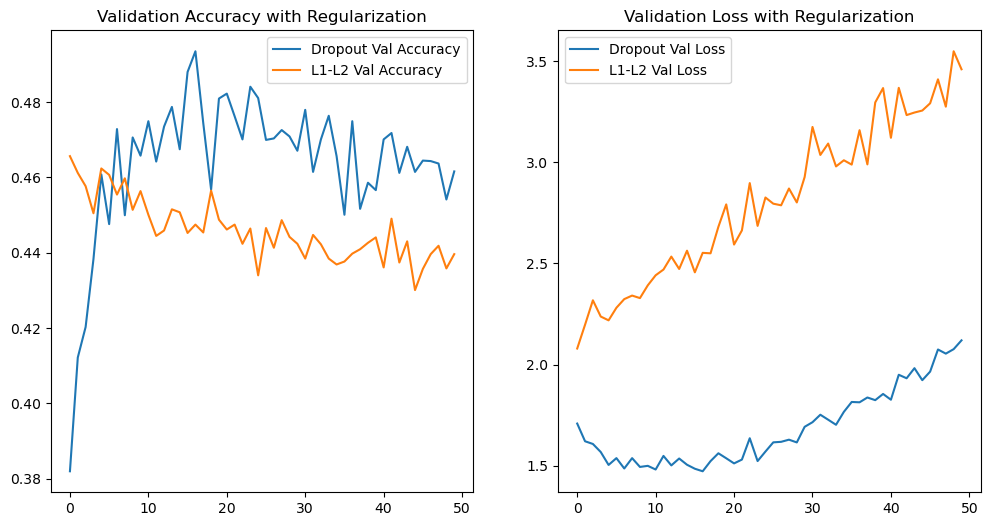

In [ ]:
# Plot regularization comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['val_accuracy'], label='Dropout Val Accuracy')
plt.plot(history_l1_l2.history['val_accuracy'], label='L1-L2 Val Accuracy')
plt.legend()
plt.title('Validation Accuracy with Regularization')
plt.subplot(1, 2, 2)
plt.plot(history_dropout.history['val_loss'], label='Dropout Val Loss')
plt.plot(history_l1_l2.history['val_loss'], label='L1-L2 Val Loss')
plt.legend()
plt.title('Validation Loss with Regularization')
plt.show()

In [ ]:
# Analyze regularization effect
print("Max val accuracy without regularization (unfrozen):", max(history_bn.history['val_accuracy']))
print("Max val accuracy with Dropout:", max(history_dropout.history['val_accuracy']))
print("Max val accuracy with L1-L2:", max(history_l1_l2.history['val_accuracy']))

Max val accuracy without regularization (unfrozen): 0.5193464159965515
Max val accuracy with Dropout: 0.49346405267715454
Max val accuracy with L1-L2: 0.46562090516090393


### Monte-Carlo Dropout

In [ ]:
model_mcd = np.stack([l1_l2_model(x_test, training=True) for _ in range(50)])
np.round(l1_l2_model.predict(x_test[:1]), 3)
np.round(model_mcd[:, :1], 3)
np.round(model_mcd.mean(axis=0)[:1], 3)

1/1 [==============================] - 0s 66ms/step


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# np.stack کارایی
# ایجاد چند آرایه
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

# استفاده از np.stack برای ترکیب آرایه‌ها
stacked = np.stack((a, b), axis=0)
print(stacked)

[[1 2 3]
 [4 5 6]]


In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
class Monte_Carlo_Dropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
# کلون کردن مدل فعلی و انتقال وزن‌ها
mc_model = keras.models.clone_model(l1_l2_model)
mc_model.set_weights(l1_l2_model.get_weights())

# جایگزینی لایه‌های Dropout با Monte_Carlo_Dropout
for i, layer in enumerate(mc_model.layers):
    if isinstance(layer, layers.Dropout):
        mc_dropout_layer = Monte_Carlo_Dropout(rate=layer.rate)
        mc_model.layers[i] = mc_dropout_layer

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
mc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# فرض می‌کنیم X_test داده‌های تست شماست
n_samples = 50  # تعداد پیش‌بینی‌ها برای تخمین عدم قطعیت
model_mcd = np.stack([mc_model(X_test, training=True) for _ in range(n_samples)])

# پیش‌بینی معمولی برای اولین نمونه
standard_pred = np.round(mc_model.predict(X_test[:1]), 3)

# نمونه‌های MC Dropout برای اولین نمونه
mcd_samples = np.round(model_mcd[:, :1], 3)

# میانگین پیش‌بینی‌های MC Dropout
mcd_mean = np.round(model_mcd.mean(axis=0)[:1], 3)

# انحراف معیار برای تخمین عدم قطعیت
mcd_std = np.round(model_mcd.std(axis=0)[:1], 3)

# نمایش نتایج
print("پیش‌بینی معمولی:", standard_pred)
print("نمونه‌های MC Dropout (اولین نمونه):", mcd_samples)
print("میانگین پیش‌بینی MC Dropout:", mcd_mean)
print("عدم قطعیت MC Dropout (انحراف معیار):", mcd_std)

1/1 [==============================] - 0s 37ms/step
پیش‌بینی معمولی: [[0.666 0.    0.334 0.    0.    0.    0.    0.    0.    0.   ]]
نمونه‌های MC Dropout (اولین نمونه): [[[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.667 0.    0.333 0.    0.    0.    

In [ ]:

# Evaluation: classification report & confusion matrix (if labels available)
try:
    import numpy as np
    import tensorflow as tf
    from sklearn.metrics import classification_report, confusion_matrix
    y_true = None; y_pred = None
    if 'val_ds' in globals():
        y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
        y_pred = np.concatenate([model.predict(val_ds),], axis=0)
    elif 'X_test' in globals() and 'y_test' in globals():
        y_true = y_test
        y_pred = model.predict(X_test)
    if y_true is not None:
        # handle probabilities vs logits
        if y_pred.ndim > 1 and y_pred.shape[-1] > 1:
            y_true_labels = np.argmax(y_true, axis=-1) if y_true.ndim>1 else y_true
            y_pred_labels = np.argmax(y_pred, axis=-1)
        else:
            y_true_labels = (y_true>0.5).astype(int).ravel() if y_true.ndim>1 else y_true
            y_pred_labels = (y_pred>0.5).astype(int).ravel()
        print("\nClassification report:\n", classification_report(y_true_labels, y_pred_labels))
        print("\nConfusion matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))
except Exception as e:
    print("Evaluation skipped:", e)


Evaluation skipped: name 'model' is not defined
